# Manipulate data
In this notebook the reference data and the user data are manipulated

In [10]:
#Imports
import json
import geopandas as gpd
from shapely import Polygon, MultiPolygon, LineString

## Reference countries
I used the following dataset <br>https://public.opendatasoft.com/explore/dataset/country_shapes/information/?location=2,-32.99024,1.40625&basemap=jawg.light<br> for the country reference shapes. The cells below contain the modification made to the data. 

In [108]:
ref_gdf = gpd.read_file('./data/reference.geojson')
ref_gdf

,geo_point_2d,cntry_name,join_name,iso2_2,iso_a2,iso2,cou_iso3_code,iso3,geometry
0,"{'lon': -170.707833227, 'lat': -14.3044053954}",American Samoa,American Samoa,AS,None,AS,ASM,ASM,MULTIPOLYGON (((-19007123.61270 -1617338.55030...
1,"{'lon': 90.4294341107, 'lat': 27.4154148028}",Bhutan,Bhutan,None,BT,BT,BTN,BTN,"MULTIPOLYGON (((10250467.07754 3107120.18973, ..."
2,"{'lon': 15.2242938734, 'lat': -0.84023182197}",Congo,Congo,None,CG,CG,COG,COG,"MULTIPOLYGON (((1768922.90691 -439280.67077, 1..."
3,"{'lon': -73.0732149222, 'lat': 3.90074916277}",Colombia,Colombia,None,CO,CO,COL,COL,"MULTIPOLYGON (((-9096256.06023 1401556.49661, ..."
4,"{'lon': 20.4828261146, 'lat': 6.57134077717}",Central African Republic,Central African Rep.,None,CF,CF,CAF,CAF,"MULTIPOLYGON (((2276851.41869 504109.86050, 22..."
...,...,...,...,...,...,...,...,...,...
233,"{'lon': -62.1869336173, 'lat': 16.7353646189}",Montserrat,Montserrat,MS,None,MS,MSR,MSR,"MULTIPOLYGON (((-6920887.96074 1882605.81336, ..."
234,"{'lon': 14.4419214047, 'lat': 35.8905224404}",Malta,Malta,MT,None,MT,MLT,MLT,"MULTIPOLYGON (((1616328.05781 4273135.83410, 1..."
235,"{'lon': 167.952596797, 'lat': -29.0376570493}",Norfolk Island,Norfolk Island,NF,None,NF,NFK,NFK,"MULTIPOLYGON (((18697774.46623 -3385973.81948,..."
236,"{'lon': 54.3350646496, 'lat': 23.9104341342}",United Arab Emirates,United Arab Emirates,None,AE,AE,ARE,ARE,"MULTIPOLYGON (((6265113.46258 2858223.99670, 6..."


### DONE: Remove small islands seperated from the mainland
Some countries, like Chile and Denmark, have a small island that is seperated from the mainland by a large distane. 
Lets remove these "outliers"

In [12]:
def rm_outlier(geom, min_length=0.8, min_area=0.05):
    if isinstance(geom, Polygon):
        return geom

    #Get current geom boundary length 
    xmin, ymin, xmax, ymax = geom.bounds
    geom_length = (xmax - xmin) + (ymax - ymin)
        
    polygons = [poly for poly in geom.geoms]
    new_polygons = []
    for idx in range(len(polygons)):
        subset = polygons.copy()
        poly = subset.pop(idx)
        new_geom = MultiPolygon(subset)
        xmin, ymin, xmax, ymax = new_geom.bounds
        length = (xmax - xmin) + (ymax - ymin)
        #Check if the polygon should be omitted 
        if (length / geom_length) > min_length or (poly.area / geom.area) > min_area:
            new_polygons.append(poly)
    
    return MultiPolygon(new_polygons)

In [13]:
ref_gdf['geometry'] = ref_gdf['geometry'].apply(rm_outlier)

In [14]:
ref_gdf.to_file('./data/reference.geojson')

### DONE: Change map projection
The projection used in the reference dataset seems to be the equirectangular projection. This leads to deformed country shapes, especially around the poles.

In [15]:
ref_gdf = ref_gdf[ref_gdf.cntry_name != 'Antarctica'].reset_index(drop=True)

In [16]:
from pyproj import Proj, Transformer 
from shapely.ops import transform

In [17]:
def change_projection(polygon):
    source_proj = Proj(init='EPSG:4326')  # WGS84 geographic coordinate system
    target_proj = Proj(init='EPSG:3857')  # Web Mercator projection
    transformer = Transformer.from_proj(source_proj, target_proj)

    return transform(transformer.transform, polygon)

In [ ]:
ref_gdf['geometry'] = ref_gdf['geometry'].apply(change_projection)

In [19]:
#ref_gdf.to_file('./data/reference.geojson')

### DONE: Merge Russia
Russia crosses the antimeridian which causes problems. Lets fix this

In [61]:
from shapely.affinity import translate


def fix_russia(russia):
    xmin, _, xmax, _ = russia.bounds
    width = xmax - xmin
    polygons = []
    for poly in russia.geoms:
        _, _, maxx, _ = poly.bounds
        if maxx < 0:
            poly = translate(poly, xoff=width)
        polygons.append(poly)

    russia = polygons[0]
    for poly in polygons[1:]:
        russia = russia.union(poly)
    return russia

In [78]:
ref_gdf.loc[ref_gdf['cntry_name']=='Russia', 'geometry'] = fix_russia(ref_gdf.loc[ref_gdf["cntry_name"]=='Russia']['geometry'].item())

In [83]:
#ref_gdf.to_file('./data/reference.geojson')

### Done: Filter countries with sparse area
Lets filter out the countries wich are extremly sparse 

In [100]:
def filter_coverage(geom, minimum=0.02):
    xmin, ymin, xmax, ymax = geom.bounds
    bounding_area = (ymax - ymin) * (xmax - xmin)
    coverage = geom.area / bounding_area
    return coverage > minimum

In [101]:
ref_gdf = ref_gdf[ref_gdf['geometry'].apply(filter_coverage)].reset_index(drop=True)

In [103]:
#ref_gdf.to_file('./data/reference.geojson')

### DONE: Decompose Polygon into MultiPolygon

In [104]:
def to_MultiPolygon(polygon):
    if isinstance(polygon, Polygon):
        return MultiPolygon([polygon])
    return polygon

In [105]:
ref_gdf['geometry'] = ref_gdf['geometry'].apply(to_MultiPolygon)

In [107]:
#ref_gdf.to_file('./data/reference.geojson')

## User drawings

In [41]:
def init_user_data(path='./data/drawings.geojson'):
    # Initialize an empty GeoJSON object
    geojson_output = {
        "type": "FeatureCollection",
        "features": []}
    
    # Write the empty GeoJSON object to a file
    with open(path, 'w') as f:
        json.dump(geojson_output, f)

In [2]:
def remove_drawing(idx, path='./data/drawings.geojson'):
    with open(path, 'r') as f:
        user_data = json.load(f)

    idx = len(user_data['features']) - 1 if idx==-1 else idx
    
    # Check if the index is valid
    if idx >= 0 and idx < len(user_data['features']):
        removed_feature = user_data['features'].pop(idx)
        print(f"Row at index {idx} removed from {path}.")
    else:
        print("Invalid index.")

    with open(path, 'w') as f:
        json.dump(user_data, f)

In [110]:
user_gdf = gpd.read_file('./data/drawings.geojson')
user_gdf

,cntry_name,timestamp,geometry
0,Denmark,2024-04-13 15:24:33.402,"MULTILINESTRING ((7.62900 7.37313, 7.62900 7.3..."
1,Cameroon,2024-04-13 18:35:43.835,"MULTILINESTRING ((45.64269 62.00000, 44.66821 ..."
2,Chile,2024-04-13 18:49:01.942,"MULTILINESTRING ((26.21384 62.00000, 26.21384 ..."
3,Peru,2024-04-13 18:50:25.626,"MULTILINESTRING ((7.01859 45.49442, 8.57993 46..."
4,Venezuela,2024-04-13 18:52:13.828,"MULTILINESTRING ((8.23077 51.84615, 7.07692 50..."
5,Belize,2024-04-13 19:05:46.957,"MULTILINESTRING ((25.19512 2.43902, 26.21951 2..."
6,Mexico,2024-04-13 19:07:53.642,"MULTILINESTRING ((2.80717 58.50224, 3.74888 58..."
7,United States of America,2024-04-13 20:34:47.098,"MULTILINESTRING ((25.27586 38.29310, 26.65517 ..."
8,Taiwan,2024-04-13 20:36:34.279,"MULTILINESTRING ((31.22857 6.80000, 31.40000 8..."
9,Chile,2024-04-16 09:15:17.773,"MULTILINESTRING ((29.76805 60.16193, 30.55580 ..."


In [4]:
#remove_drawing(-1)

Row at index 23 removed from ./data/drawings.geojson.


### Plot user drawings

In [111]:
import matplotlib.pyplot as plt
from countryguess.data import TestDataset, Dataset
from countryguess.utils import poly_to_img 

In [112]:
test_data = TestDataset(shape=(128, 128))
ref_data = Dataset(shape=(128, 128))

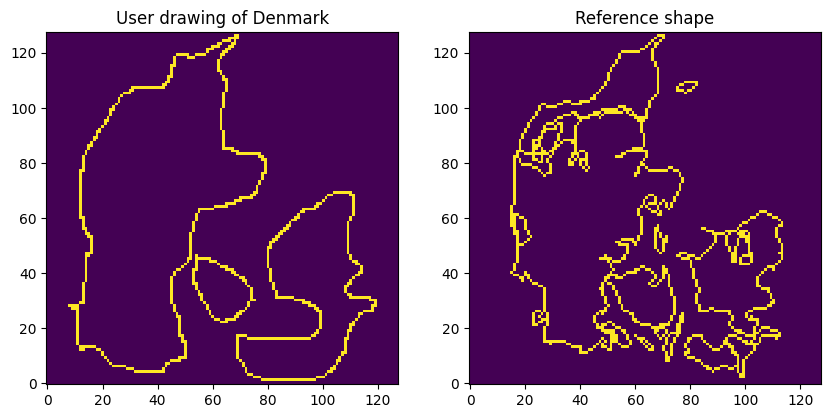

In [119]:
sample = test_data[0]

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(sample["drawing"], interpolation='nearest', origin='lower')
axs[0].set_title(f"User drawing of {sample['country_name']}") 

img = poly_to_img(ref_data.from_country_name(sample['country_name']), ref_data.shape)
axs[1].imshow(img, interpolation='nearest', origin='lower')
axs[1].set_title("Reference shape")
plt.show()